You will learn how to work with and plot raster data using the rasterio package for Python.

## Learning Objectives
After completing this section of the textbook, you will be able to:

- Open raster data using Python.
-  Be able to list and identify 3 spatial attributes of a raster dataset: extent, crs and resolution.
- Explore and plot the distribution of values within a raster using histograms.
- Access metadata stored within a GeoTIFF raster file via TIF tags in Python.
- Use raster math in Python to derive new rasters.
- Reclassify a raster dataset in Python using a set of defined values.
- Crop a raster dataset in Python using a vector extent object derived from a shapefile.
- Reproject a raster using rasterio.

**rioxarray and xarray**

#### Cal recordar que un raster es una matriu8 per tant la llibreria numpy és de gran importància per a l'analisi de rasters

## Ch 4 Fundementals of raster data

The GeoTIFF file format is often used to store raster data. Learn how to to open and explore raster data stored as GeoTIFF files in Python.

In this chapter you will learn how to use the open source Python packages rasterio combined with numpy and earthpy to open, manipulate and plot raster data in Python. In this chapter, you will learn how to open and plot a lidar raster dataset in Python. You will also learn about key attributes of a raster dataset:

- Spatial resolution
- Spatial extent and
- Coordinate reference systems

## 2_ Open, Plot and Explore Raster Data with Python and Xarray


#### Learning Objectives
- Open, plot, and explore raster data using Python.
- Handle no data values in raster data.
- Create plotting extents so you can plot raster and vector data together using matplotlib.
- Explore raster data using histograms and descriptive statistics.

In this lesson you will learn more about working with lidar derived raster data that represents both terrain / elevation data (elevation of the earth’s surface), and surface elevation (elevation at the tops of trees, buildings etc above the earth’s surface). If you want to read more about how lidar data are used to derive raster based surface models, you can check out this chapter on lidar remote sensing data and the various raster data products derived from lidar data.



![title](lidar.png)

#### Data Tip: The data used in this lesson are NEON (National Ecological Observatory Network) data.

In [3]:
# Import necessary packages
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Use geopandas for vector data and xarray for raster data
import geopandas as gpd
import rioxarray as rxr

import earthpy as et

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="white")

In [4]:
# Get data and set working directory
et.data.get_data("colorado-flood")
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))

You then open the data using rioxarray - rxr.open_rasterio("path-to-raster-here").

In [6]:
# Define relative path to file
dem_pre_path = os.path.join("colorado-flood",
                            "spatial",
                            "boulder-leehill-rd",
                            "pre-flood",
                            "lidar",
                            "pre_DTM.tif")

dtm_pre_arr = rxr.open_rasterio(dem_pre_path)
dtm_pre_arr

<xarray.DataArray (band: 1, y: 2000, x: 4000)>
[8000000 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.72e+05 4.72e+05 4.72e+05 ... 4.76e+05 4.76e+05
  * y            (y) float64 4.436e+06 4.436e+06 ... 4.434e+06 4.434e+06
    spatial_ref  int32 0
Attributes:
    _FillValue:    -3.4028234663852886e+38
    scale_factor:  1.0
    add_offset:    0.0

When you open raster data using xarray or rioxarray you are creating an **xarray**.DataArray. The. DataArray object stores the:

- raster data in a numpy array format
- spatial metadata including the CRS, spatial extent of the object
- and any metadata


**Xarray** and **numpy** provide an efficient way to work with and process raster data. xarray also supports dask and parallel processing which allows you to more efficiently process larger datasets using the processing power that you have on your computer

When you add rioxarray to your package imports, you further get access to spatial data processing using xarray objects. Below, you can view the spatial extent (bounds()) and CRS of the data that you just opened above.

In [8]:
# View the Coordinate Reference System (CRS) & spatial extent
print("The CRS for this data is:", dtm_pre_arr.rio.crs)
print("The spatial extent is:", dtm_pre_arr.rio.bounds())

The CRS for this data is: EPSG:32613
The spatial extent is: (472000.0, 4434000.0, 476000.0, 4436000.0)


The **nodata** value (or fill value) is also stored in the xarray object.

In [9]:
# View no data value
print("The no data value is:", dtm_pre_arr.rio.nodata)

The no data value is: -3.4028235e+38


Once you have imported your data, you can plot is using xarray.plot().

In [15]:
type(dtm_pre_arr)

xarray.core.dataarray.DataArray

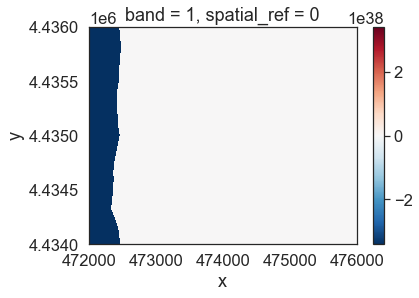

In [11]:
dtm_pre_arr.plot()


The data above should represent terrain model data. However, the range of values is not what is expected. These data are for Boulder, Colorado where the elevation may range from 1000-3000m. There may be some **outlier** values in the data that may need to be addressed. Below you look at the distribution of pixel values in the data by plotting a histogram.

Notice that there seem to be a lot of pixel values in the negative range in that plot.

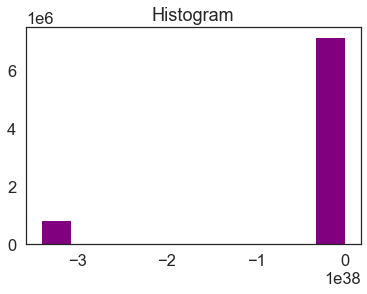

In [12]:
# A histogram can also be helpful to look at the range of values in your data
# What do you notice about the histogram below?
dtm_pre_arr.plot.hist(color="purple")
plt.show()

Looking at the min and max values of the data, you can see a very small negative number for the minimum. This number matches the nodata value that you looked at above.

In [14]:
print("the minimum raster value is: ", np.nanmin(dtm_pre_arr.values)) #numpy 
print("the maximum raster value is: ", np.nanmax(dtm_pre_arr.values))

the minimum raster value is:  -3.4028235e+38
the maximum raster value is:  2087.43


# Raster Data Exploration - Min and Max Values
Looking at the minimum value of the data, there is one of two things going on that need to be fixed:

- there may be no data values in the data with a negative value that are skewing your plot colors
- there also could be outlier data in your raster

You can explore the first option - that there are no data values by reading in the data and masking no data values using the masked=True parameter like this:

- rxr.open_rasterio(dem_pre_path, masked=True)

Above you may have also noticed that the array has an additional dimension for the “band”. While the raster only has one layer - there is a 1 in the output of shape that could get in the way of processing.

You can remove that additional dimension using .squeeze()

In [16]:
# Notice that the shape of this object has a 1 at the beginning
# This can cause issues with plotting
dtm_pre_arr.shape

(1, 2000, 4000)

In [18]:
# Open the data and mask no data values
# Squeeze reduces the third dimension given there is only one "band" or layer to this data
dtm_pre_arr = rxr.open_rasterio(dem_pre_path, masked=True).squeeze() # torna a obrir the raster layer with squeeze method

# Notice there are now only 2 dimensions to your array
dtm_pre_arr.shape

(2000, 4000)

Plot the data again to see what has changed. Now you have a reasonable range of data values and the data plot as you might expect it to.

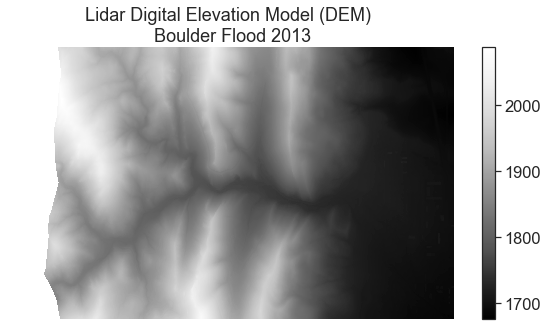

In [19]:
# Plot the data and notice that the scale bar looks better
# No data values are now masked
f, ax = plt.subplots(figsize=(10, 5))
dtm_pre_arr.plot(cmap="Greys_r",
                 ax=ax)
ax.set_title("Lidar Digital Elevation Model (DEM) \n Boulder Flood 2013")
ax.set_axis_off()
plt.show()

The histogram has also changed. Now, it shows a reasonable distribution of pixel values.

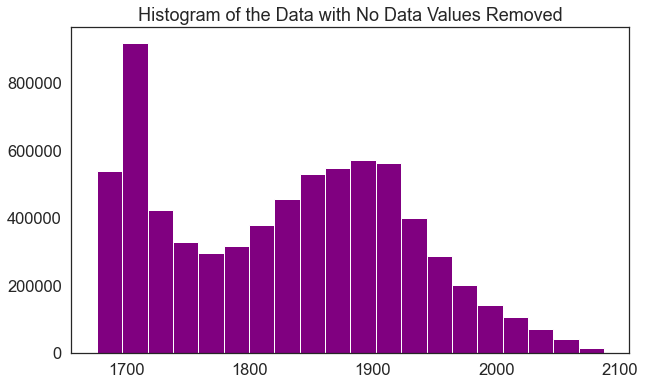

In [20]:
f, ax = plt.subplots(figsize=(10, 6))
dtm_pre_arr.plot.hist(color="purple",
                      bins=20)
ax.set_title("Histogram of the Data with No Data Values Removed")
plt.show()

Notice that now the minimum value looks more like an elevation value (which should most often not be negative).

In [21]:
print("The minimum raster value is: ", np.nanmin(dtm_pre_arr.data))
print("The maximum raster value is: ", np.nanmax(dtm_pre_arr.data))

The minimum raster value is:  1676.21
The maximum raster value is:  2087.43


## Plot Raster and Vector Data Together
If you want, you can also add shapefile overlays to your raster data plot. Below you open a single shapefile using Geopandas that contains a boundary layer that you can overlay on top of your raster dataset. 

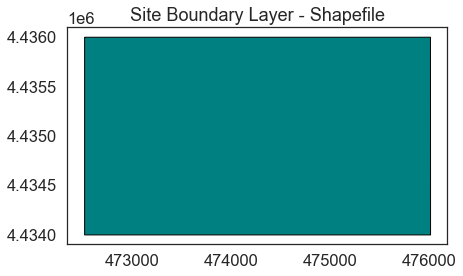

In [22]:
# Open site boundary vector layer
site_bound_path = os.path.join("colorado-flood",
                               "spatial",
                               "boulder-leehill-rd",
                               "clip-extent.shp")
site_bound_shp = gpd.read_file(site_bound_path)

# Plot the vector data
f, ax = plt.subplots(figsize=(8,4))
site_bound_shp.plot(color='teal',
                    edgecolor='black',
                    ax=ax)
ax.set(title="Site Boundary Layer - Shapefile")
plt.show()

Once you have your shapefile open, can plot the two datasets together and begin to create a map.

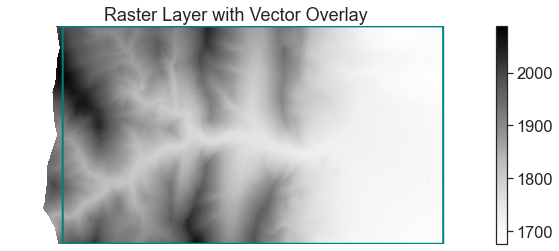

In [24]:
f, ax = plt.subplots(figsize=(11, 4))

dtm_pre_arr.plot.imshow(cmap="Greys",
                        ax=ax)
site_bound_shp.plot(color='None',
                    edgecolor='teal',
                    linewidth=2,
                    ax=ax,
                    zorder=4)

ax.set(title="Raster Layer with Vector Overlay")
ax.axis('off')
plt.show()